In [147]:
%reload_ext autoreload
%autoreload 2

import datetime as dt
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..\..')

from Crypto.lib.backtest_statistics import account_curve_statistics
from Crypto.lib.constants import COINBASE_CRYPTOS
from Crypto.lib.data import import_data

pd.options.mode.chained_assignment = None

In [148]:
close = import_data()
close = close.resample("D", label='right').last().ffill()

In [149]:
def compute_signal(close, speed):
    ma_xover = (close.ewm(speed).mean() - close.ewm(3 * speed).mean())
    iosc = ma_xover / ma_xover.ewm(3 * speed).std()
    iosc = iosc.clip(-3., 3.)
    iosc = iosc.ffill(limit=5)
    return iosc

def compute_daily_pnl(signal, close, cost):
    signal = signal.sub(signal.mean(axis=1), axis=0).div(signal.std(axis=1), axis=0)
    close = close.reindex_like(signal)
    positions = (-signal / close).ffill(limit=5)  # $-neutral
    notional = positions * close
    trades = positions.diff().fillna(0.0)
    costs = trades.abs() * close * cost
    
    pnl_raw = positions.shift() * close.diff()
    pnl_cost = pnl_raw - costs
    pnl_raw = pnl_raw.resample("D").sum().cumsum()
    pnl_cost = pnl_cost.resample("D").sum().cumsum()
    
    pnl_long_raw = positions.shift().where(positions.shift() > 0) * close.diff()
    pnl_short_raw = positions.shift().where(positions.shift() < 0) * close.diff()
    pnl_long_raw = pnl_long_raw.resample("D").sum().cumsum()
    pnl_short_raw = pnl_short_raw.resample("D").sum().cumsum()
    
    return {
        "pnl_raw": pnl_raw,
        "pnl_cost": pnl_cost,
        "notional": notional,
        "positions": positions,
        "costs": costs,
        "pnl_long_raw": pnl_long_raw,
        "pnl_short_raw": pnl_short_raw,
    }

def print_minutes(minutes):
    if minutes < 60:
        return f"{minutes}min"
    else: 
        return f"{minutes // 60}h{minutes % 60}min"
    
def print_days(days):
    return f"{days}d"

# Weights analysis

In [150]:
weights = compute_signal(close, 32)
weights = weights.loc["2017":, COINBASE_CRYPTOS]
weights = weights.sub(weights.mean(axis=1), axis=0).div(weights.std(axis=1), axis=0)

In [151]:
weights.describe().T

count      mean       std       min       25%       50%       75%  \
BTC   1565.0  0.627584  0.572591 -0.482369  0.246232  0.541077  0.950606   
LTC   1563.0  0.064157  0.708222 -1.500000 -0.396336  0.221555  0.637312   
ADA   1158.0 -0.159578  0.674524 -1.645811 -0.703548 -0.183342  0.285056   
ETH   1565.0  0.339958  0.504440 -1.500000  0.047806  0.367572  0.557391   
LINK   671.0  0.586162  1.370522 -2.754611  0.415142  0.941470  1.553477   
XLM   1127.0 -0.478537  0.868927 -2.243588 -1.151041 -0.347754  0.066976   
BCH   1240.0 -0.592615  0.720373 -2.031290 -1.218345 -0.671004  0.090390   
EOS   1401.0 -0.233444  0.924955 -2.211710 -0.971726 -0.108537  0.418360   
XTZ   1399.0  0.387712  0.846538 -2.009435 -0.137856  0.299974  0.858916   
ETC   1563.0 -0.129943  0.611291 -1.611980 -0.519504 -0.105521  0.358588   
DAI   1121.0 -0.049853  1.764245 -3.425570 -1.401195 -0.293620  1.463811   
MKR   1066.0  0.015433  0.988167 -1.825333 -0.500372 -0.075860  0.576386   
MANA  1370.0 -0.112590  0.875907 -2.474874 -0.585504  0.000647  0.426824   
BAT   1210.0 -0.303654  0.872255 -2.592641 -0.923697 -0.281441  0.281593   

           max  
BTC   2.174384  
LTC   1.283980  
ADA   1.416163  
ETH   1.589192  
LINK  2.172435  
XLM   2.151454  
BCH   0.724459  
EOS   1.941014  
XTZ   2.699751  
ETC   1.957886  
DAI   3.025656  
MKR   2.619311  
MANA  1.889944  
BAT   2.279714

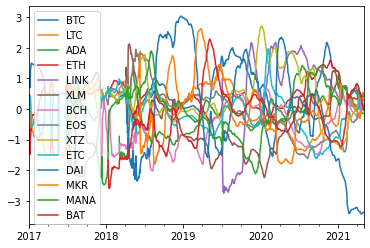

In [152]:
weights.resample("B").last().plot();

# Simulations

In [153]:
def plot_simulation(markets, cost, compute_signal):
    for speed in [2, 4, 8, 16, 32, 64, 128, 256]:
        weights = compute_signal(close, speed)
        weights = weights.loc["2017":"2019", markets]
        res = compute_daily_pnl(weights, close, cost)

        fig, axes = plt.subplots(1, 3, figsize=(30, 6))
        fig.suptitle(f"Speed: fast {print_days(speed)}, slow {print_days(speed * 3)}")

        sr_all_raw = account_curve_statistics(res["pnl_raw"].sum(axis=1)).Sharpe
        sr_all_cost = account_curve_statistics(res["pnl_cost"].sum(axis=1)).Sharpe

        sr_raw = account_curve_statistics(res["pnl_raw"]).Sharpe
        sr_cost = account_curve_statistics(res["pnl_cost"]).Sharpe

        res["pnl_raw"].sum(axis=1).plot(ax=axes[0], label="Raw", title=f"All (SR: raw={sr_all_raw:.2f}, cost={sr_all_cost:.2f})");
        res["pnl_cost"].sum(axis=1).plot(ax=axes[0], label="Cost");
        axes[0].legend();

        sr_long_raw = account_curve_statistics(res["pnl_long_raw"].sum(axis=1)).Sharpe
        sr_short_raw = account_curve_statistics(res["pnl_short_raw"].sum(axis=1)).Sharpe

        res["pnl_long_raw"].sum(axis=1).plot(ax=axes[1], label="Longs", title=f"Long/Short Raw (SR: longs={sr_long_raw:.2f}, shorts={sr_short_raw:.2f})");
        res["pnl_short_raw"].sum(axis=1).plot(ax=axes[1], label="Shorts");
        axes[1].legend();

        res["pnl_raw"].columns = [f"{x} (SR:{sr_raw.loc[x]:.1f})" for x in res["pnl_raw"].columns]
        res["pnl_raw"].plot(ax=axes[2], title="Per coin");

## Coinbase cryptos

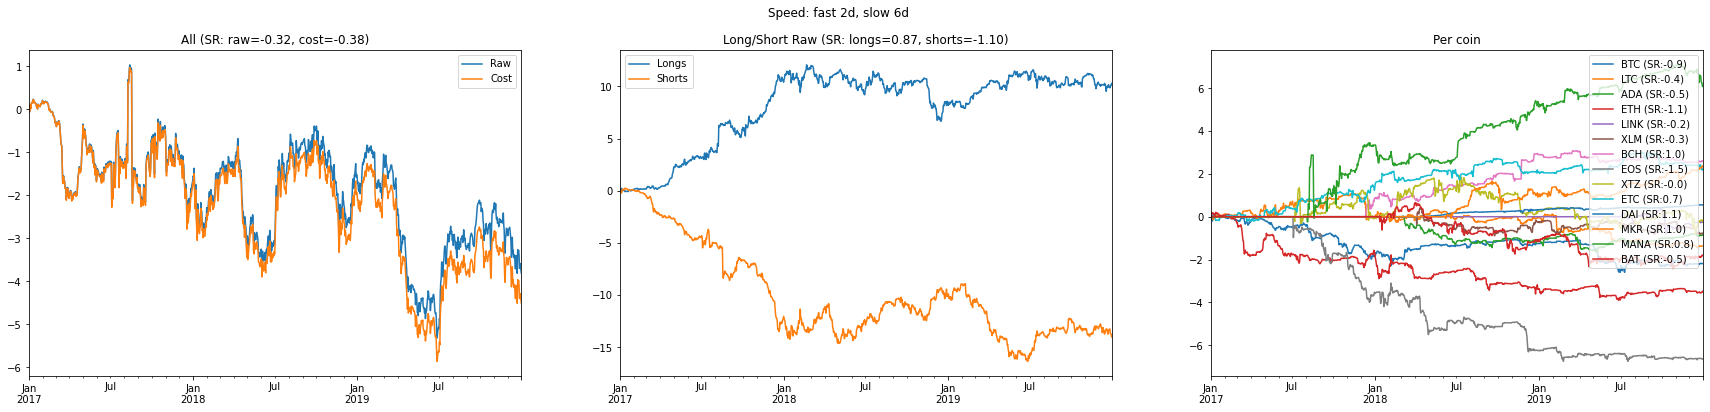

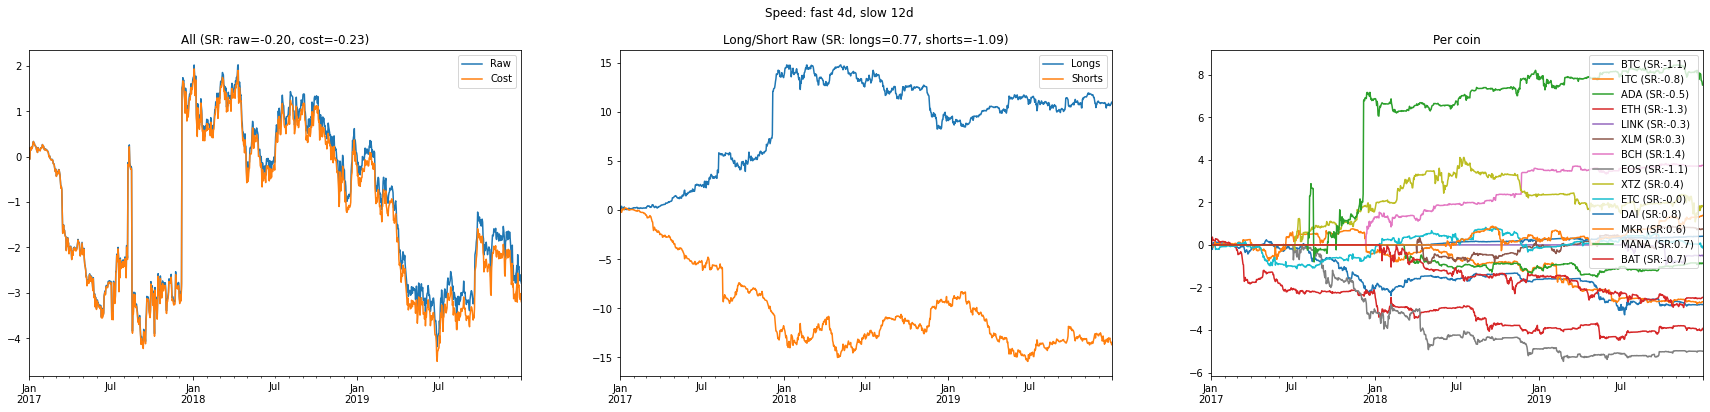

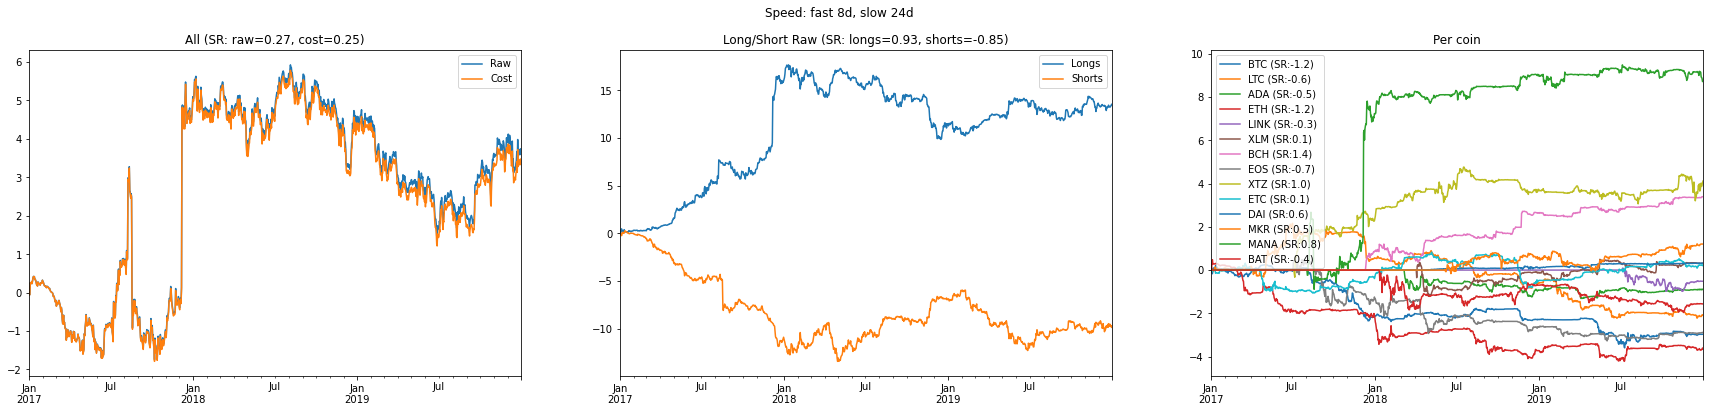

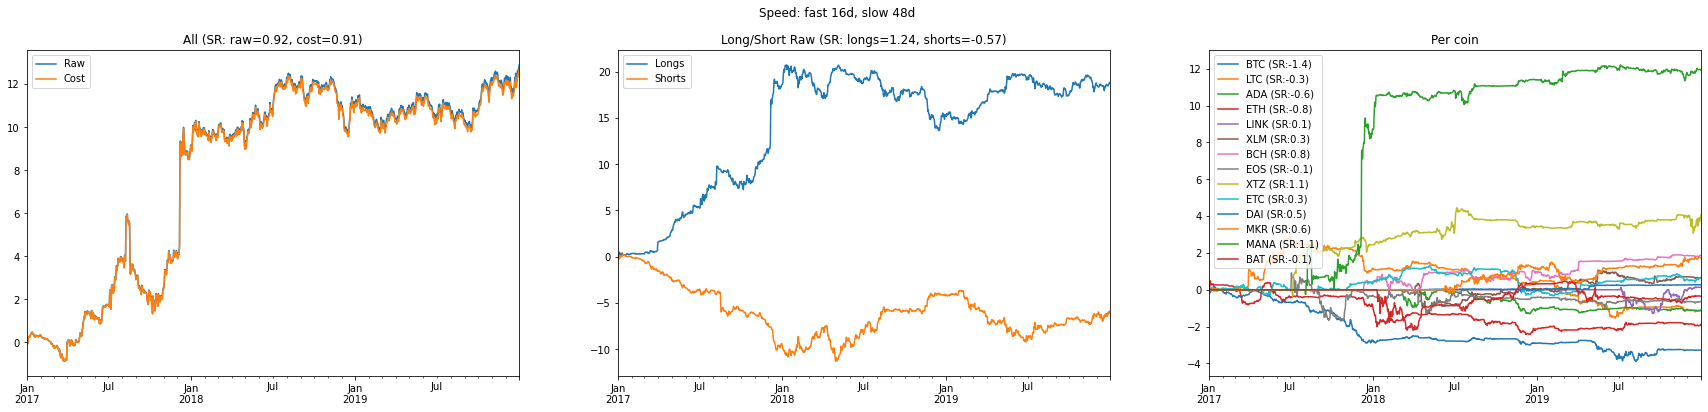

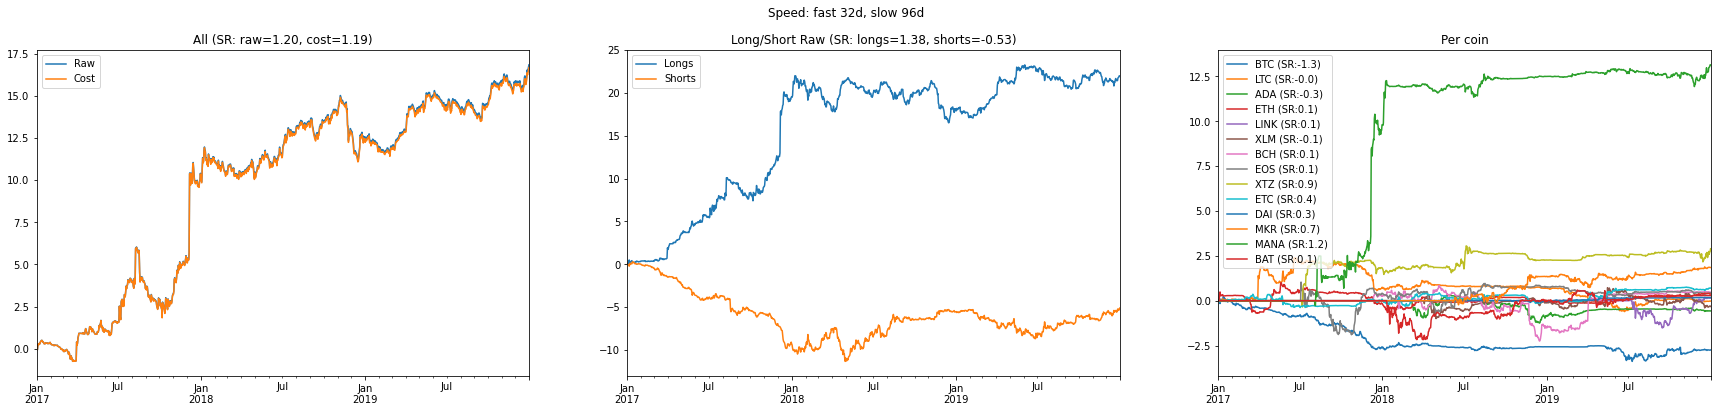

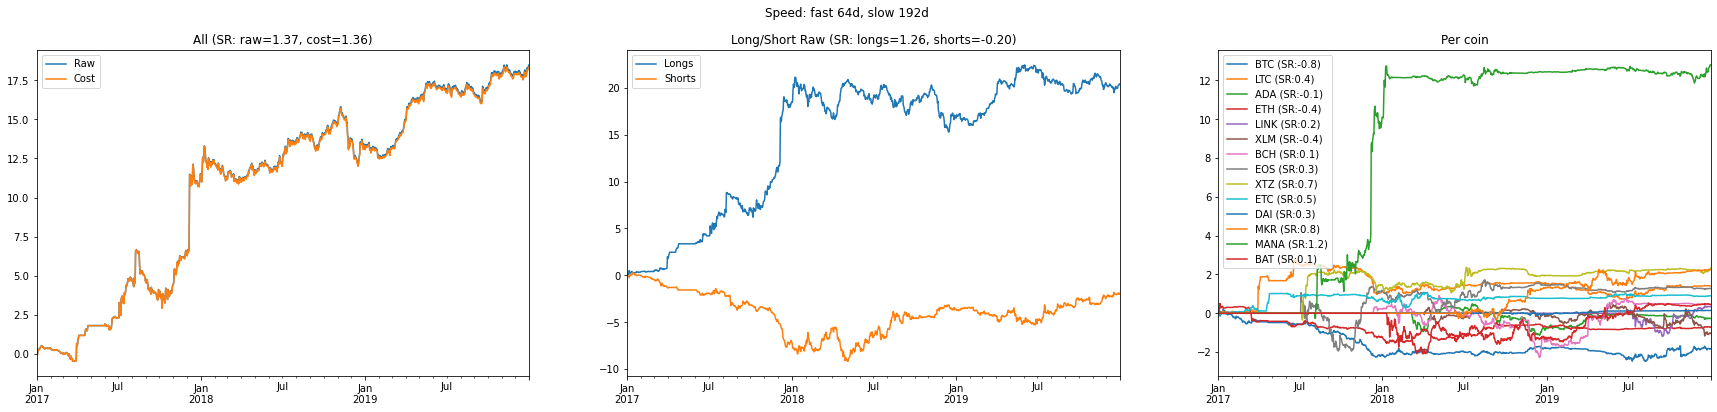

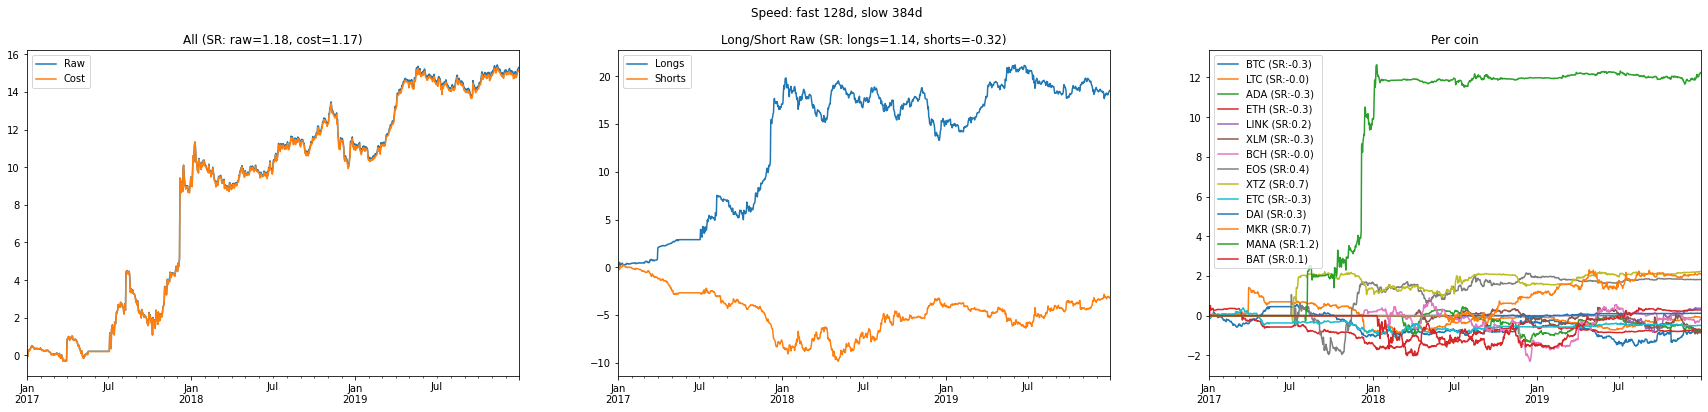

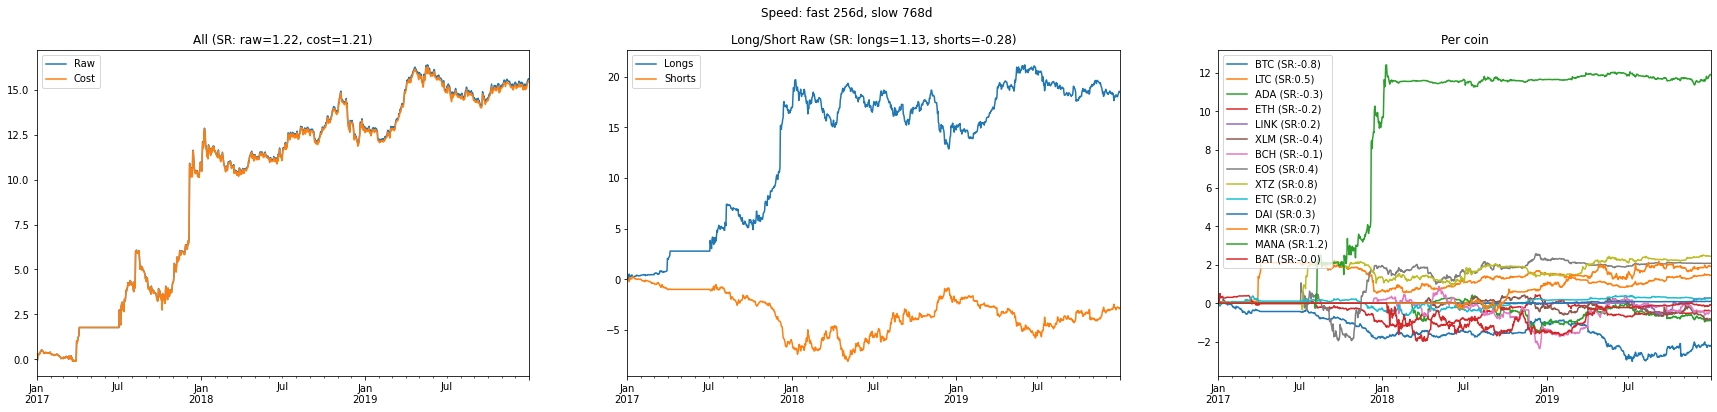

In [154]:
markets = COINBASE_CRYPTOS
cost = 0.0003
plot_simulation(markets, cost, compute_signal)

## All cryptos

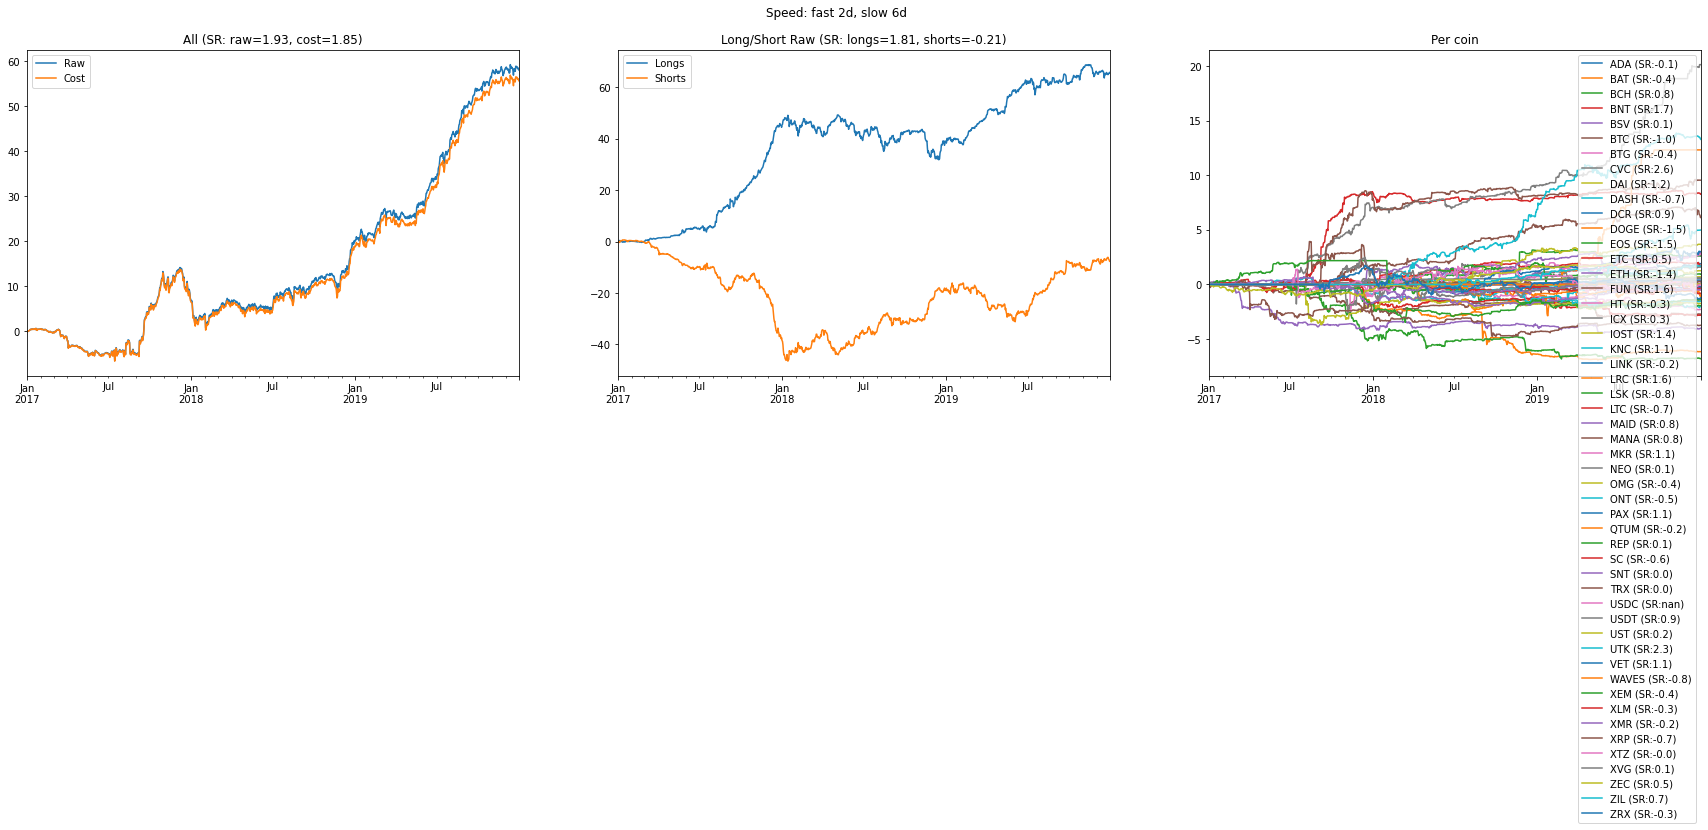

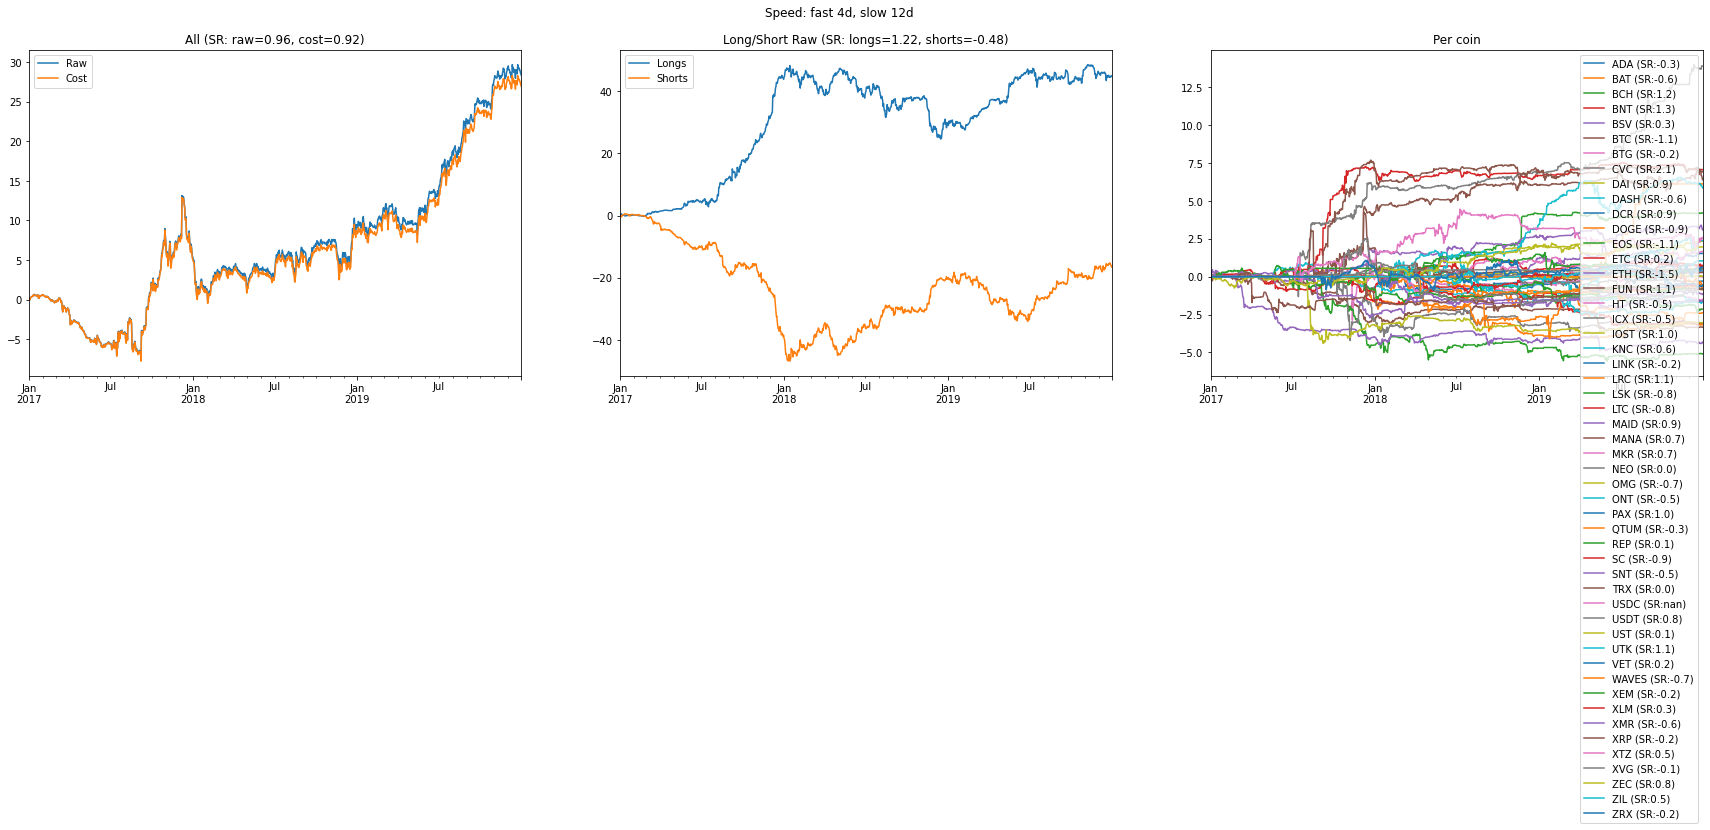

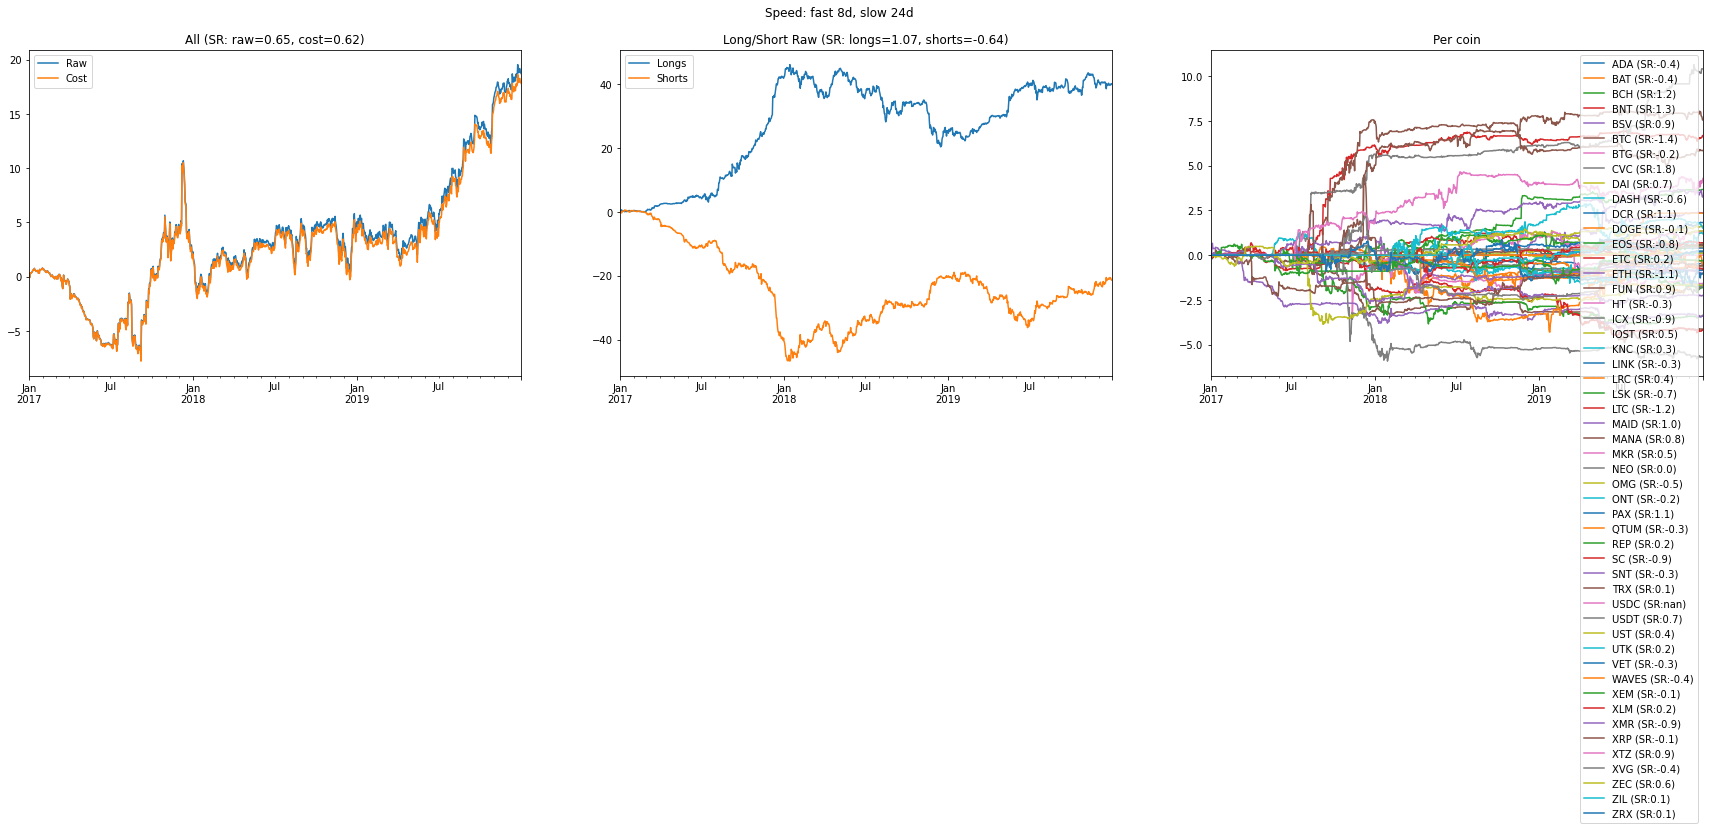

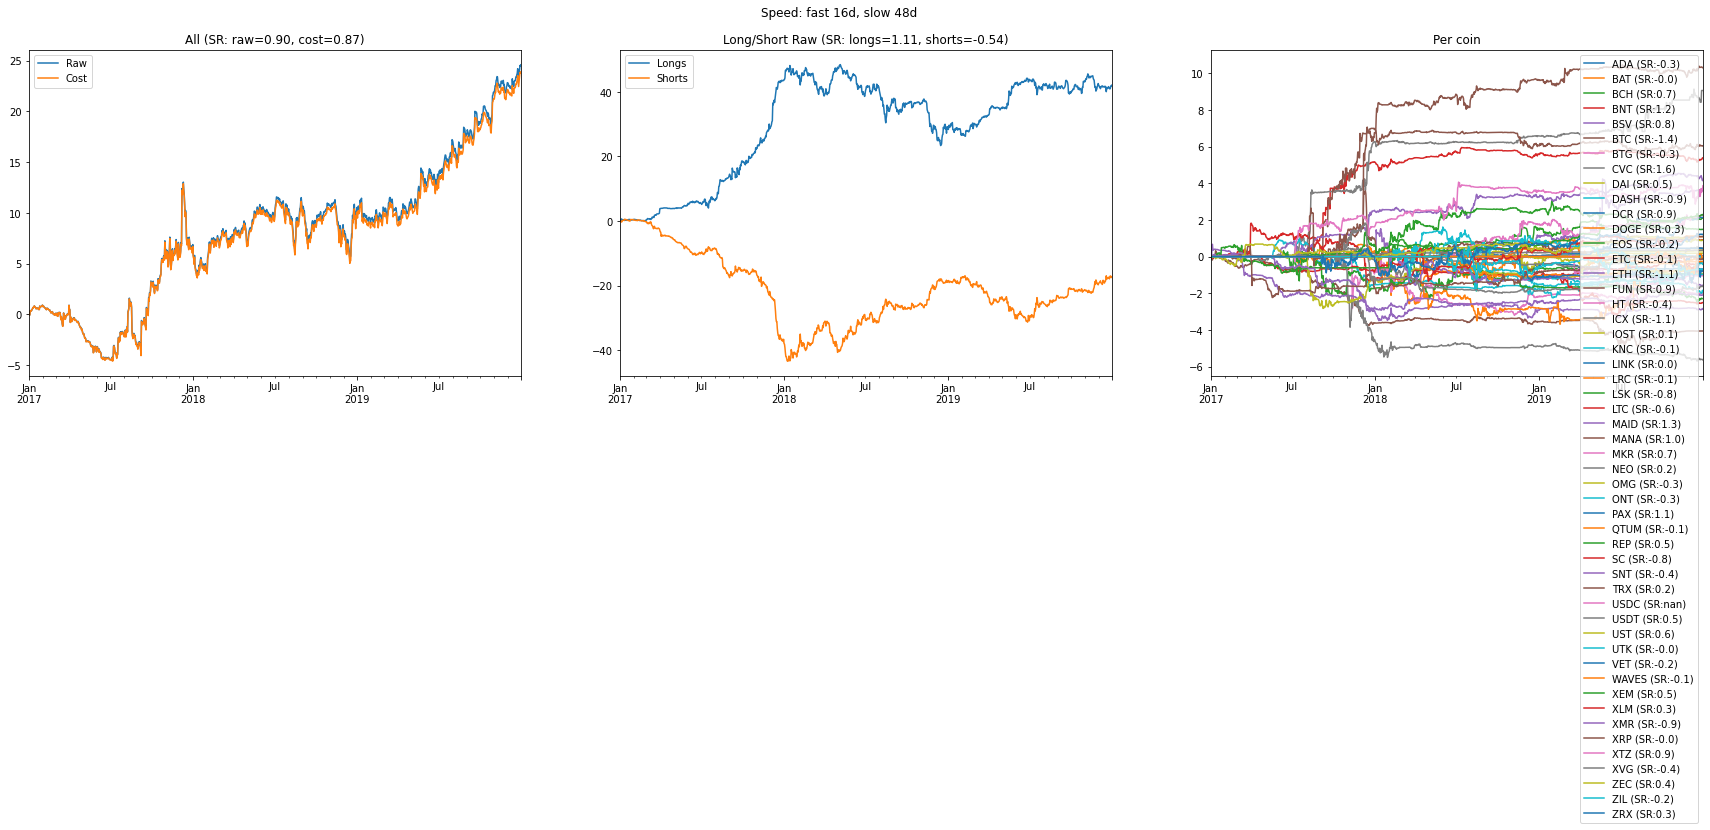

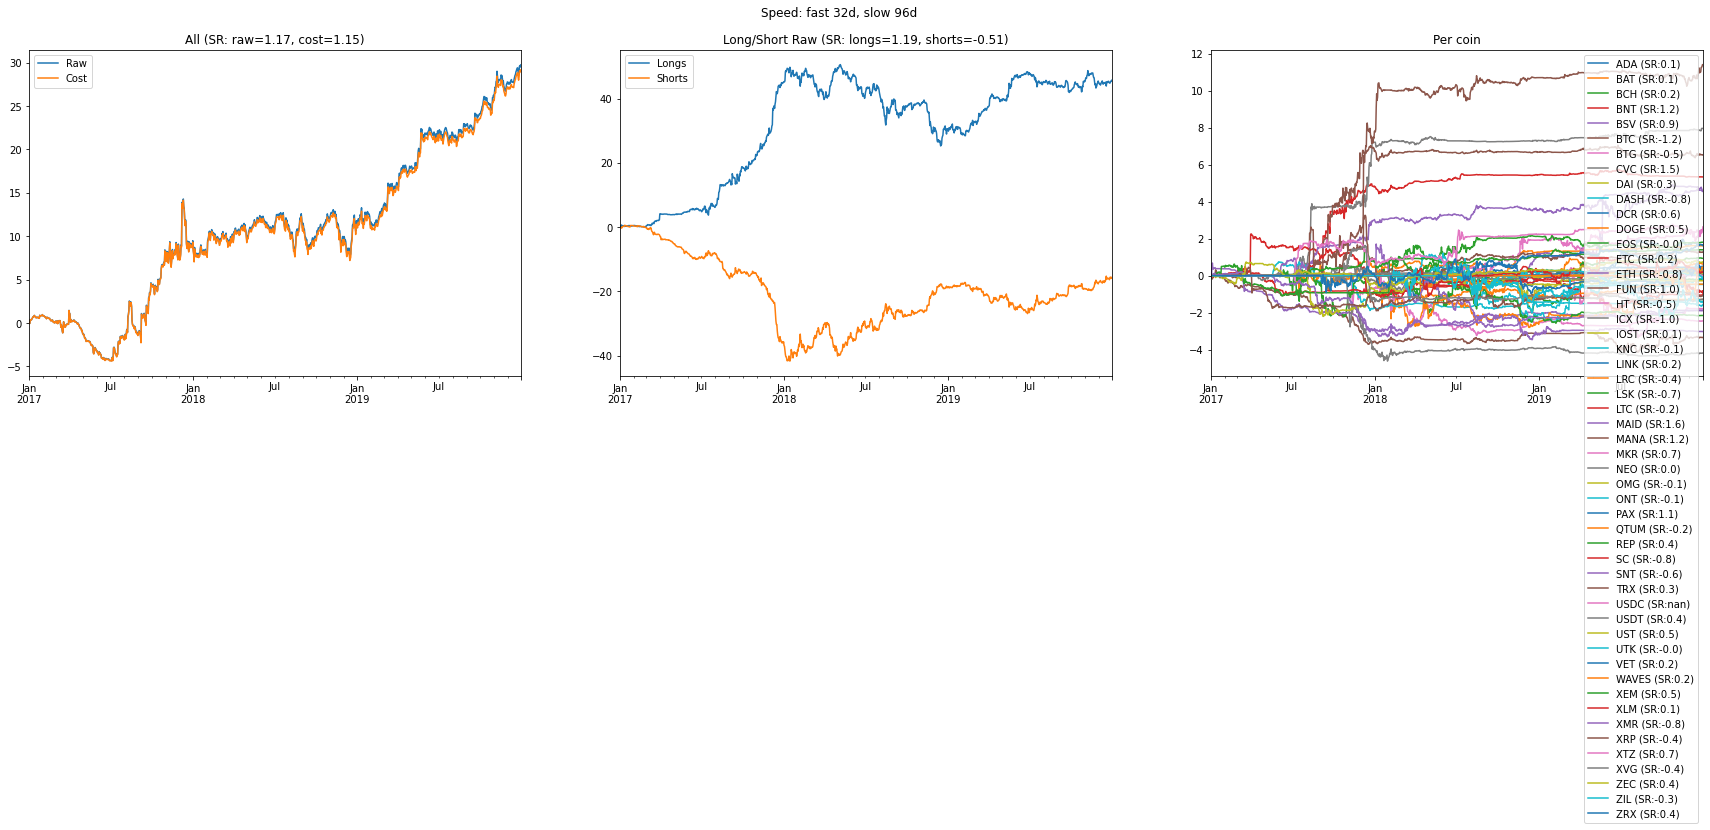

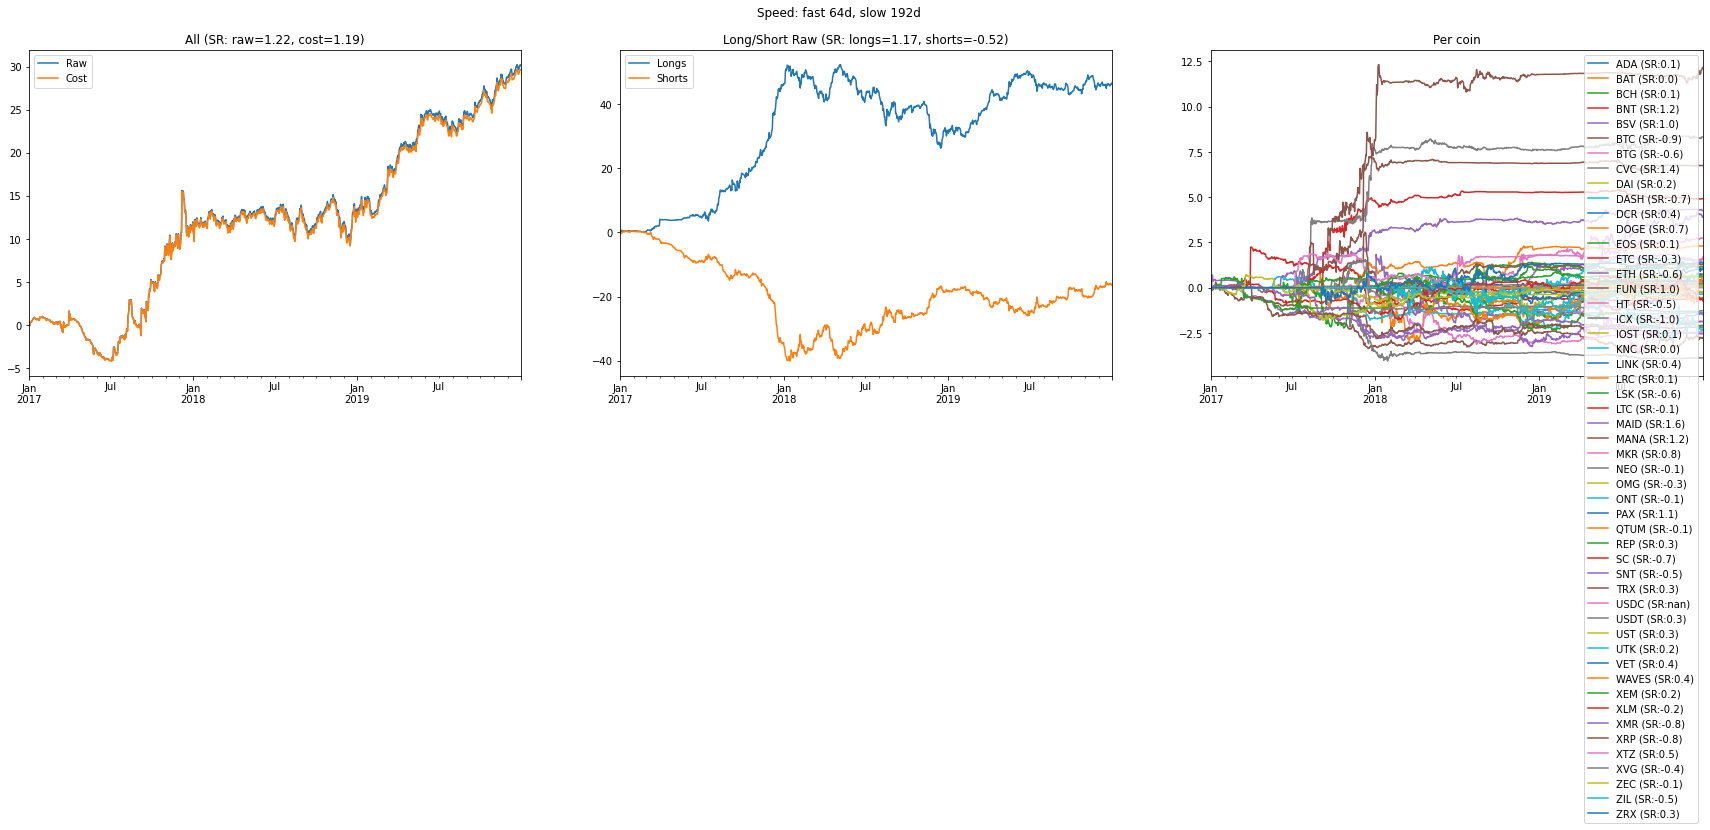

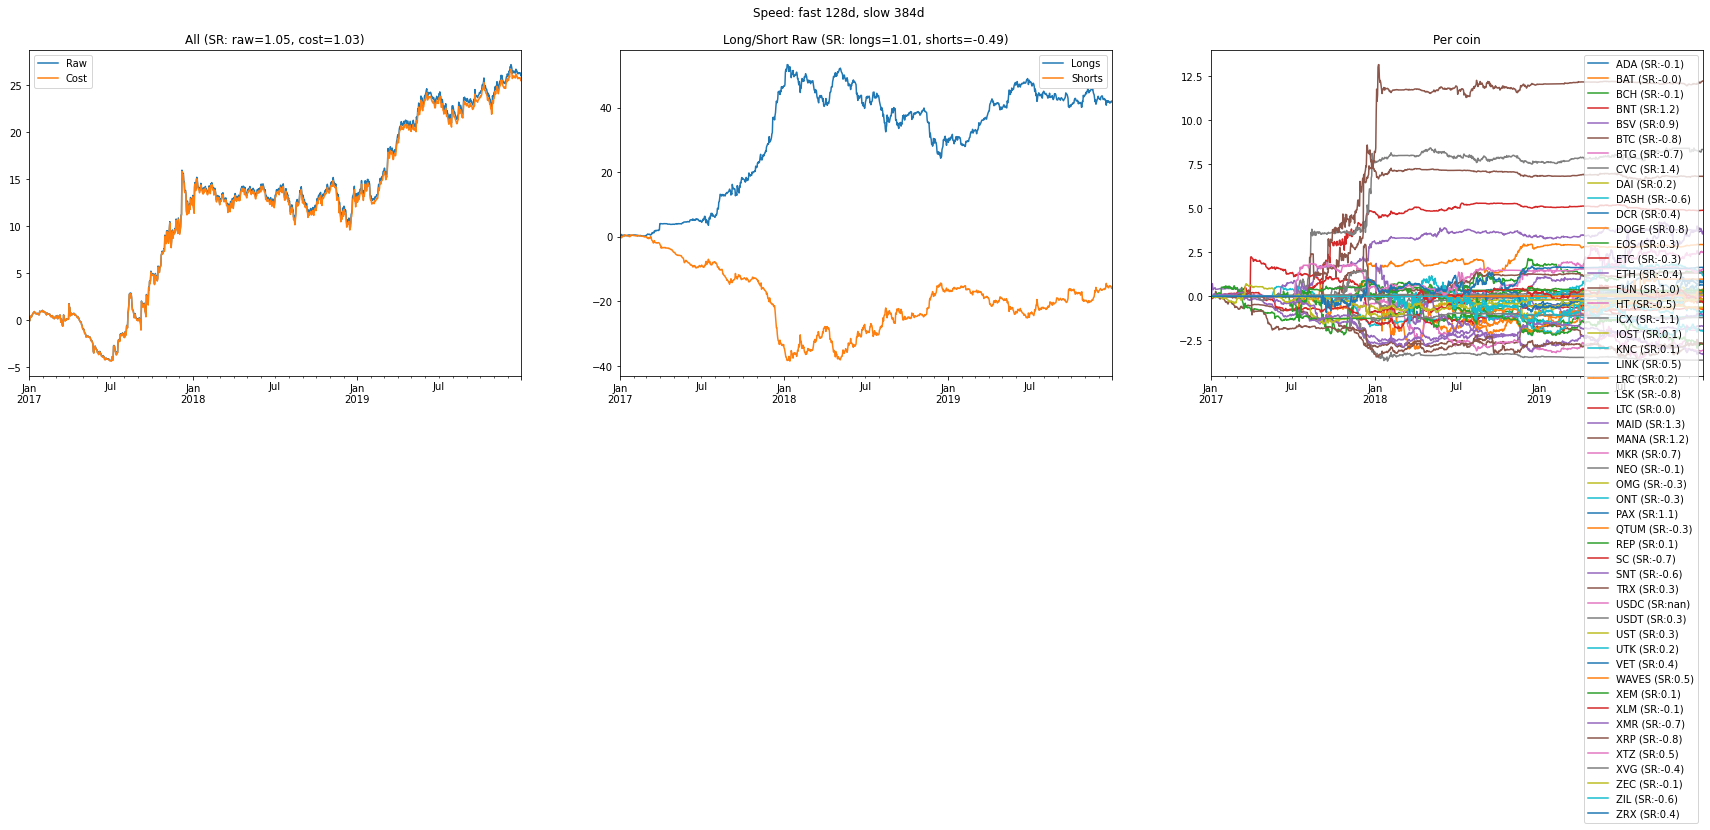

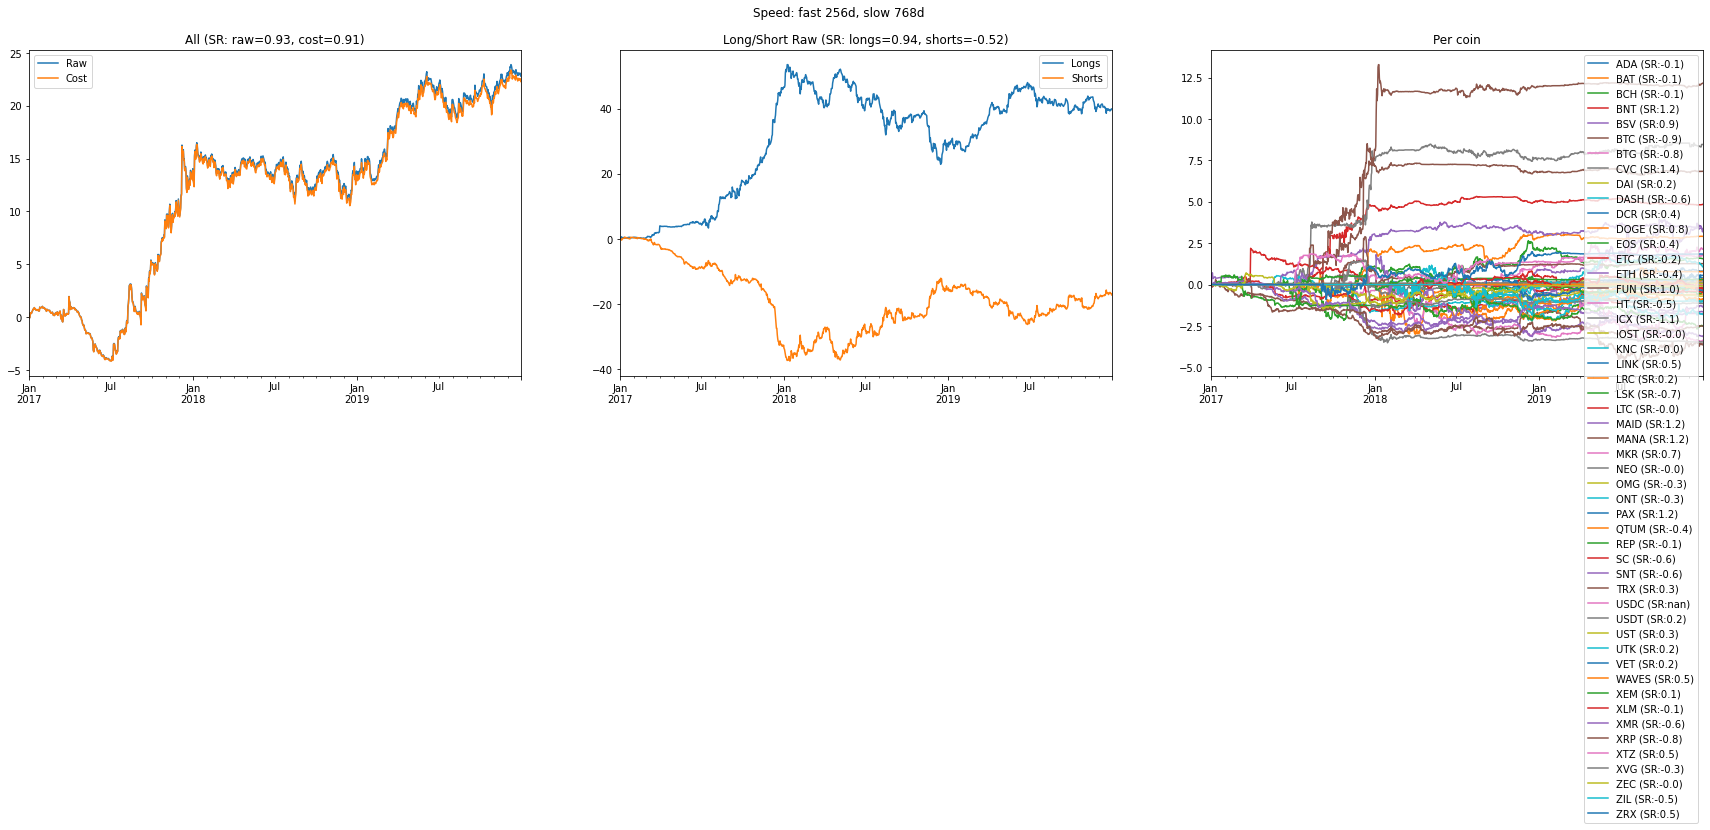

In [155]:
markets = close.columns
cost = 0.0003
plot_simulation(markets, cost, compute_signal)